<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoregressive Integrated Moving Average (ARIMA)
https://github.com/AidanCooper/forecasting/blob/master/ARIMA/household-electricity-consumption.ipynb


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

In [ ]:
df = pd.read_csv('/content/BE.csv', parse_dates=[0], index_col='Date')
print(df.shape)
df.head()

(52416, 3)


,Prices,Generation forecast,System load forecast
Date,,,
2011-01-09 00:00:00,32.54,63065.0,63000.0
2011-01-09 01:00:00,21.55,62715.0,58800.0
2011-01-09 02:00:00,15.71,61952.0,58500.0
2011-01-09 03:00:00,10.58,59262.0,54300.0
2011-01-09 04:00:00,10.32,56883.0,51900.0


In [ ]:
dataset_name = 'Household Electricity Consumption'
dataset_abbr = 'HEC'
model_name = 'ARIMA'
context_length = 52416 # Four weeks
prediction_length = 17472

In [ ]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

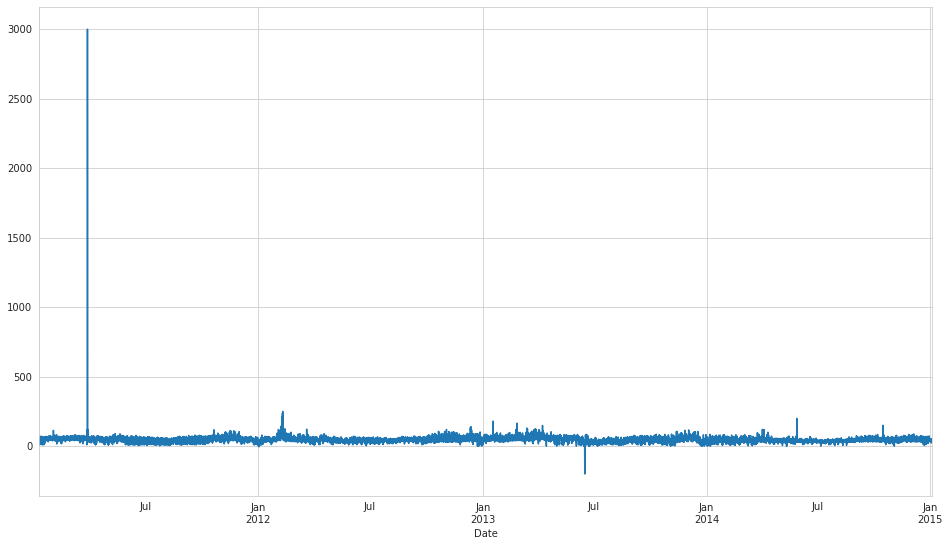

In [ ]:
ts_ex = ' Prices'
df_ex = df.loc[:, ts_ex]

# Plot data from first five days
df_ex.iloc[:34944].plot();

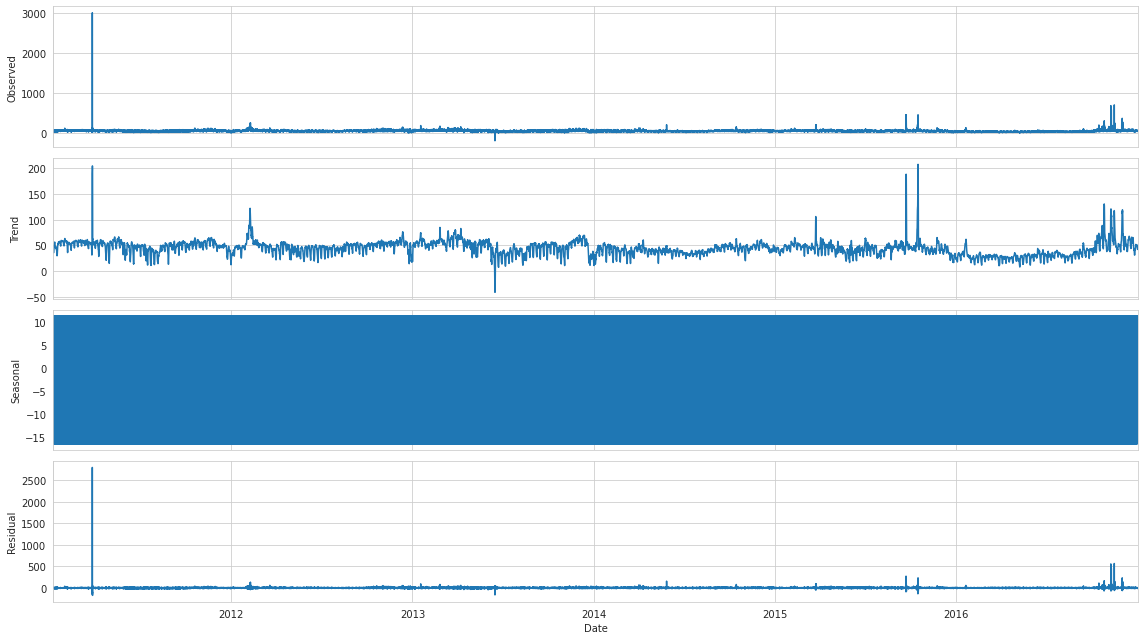

In [ ]:
fig = seasonal_decompose(df_ex, model='additive').plot()

In [ ]:
dftest = adfuller(df_ex, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.738527e+01
p-value                        5.045691e-30
#Lags Used                     5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64

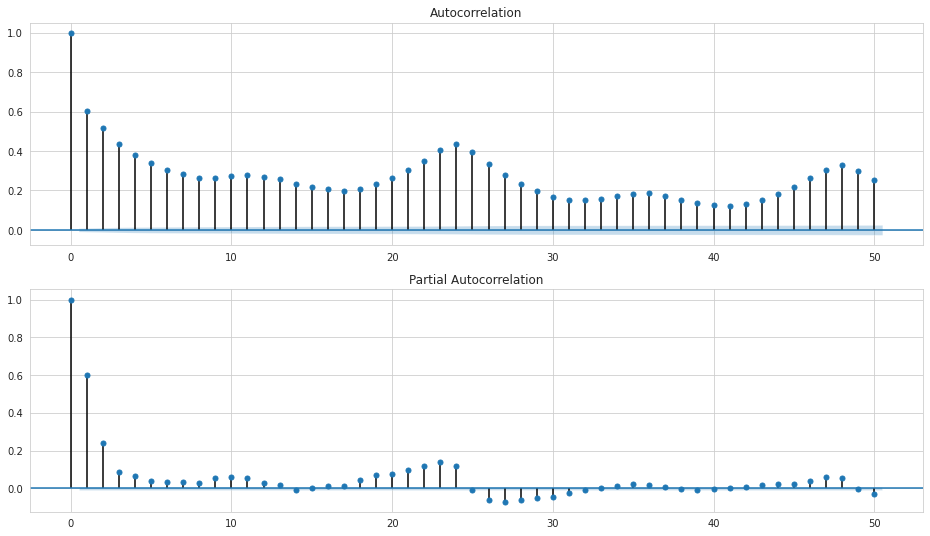

In [ ]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex, lags=50, ax=ax[1])

In [ ]:
from itertools import product

ps = range(0, 5) # Up to 4 AR terms
ds = range(0, 2) # Either no or first differencing
qs = range(0, 5) # Up to 4 MA terms

params = product(ps, ds, qs)
params_list = list(params)
print("Number of parameter combinations for grid search: {}".format(len(params_list)))

Number of parameter combinations for grid search: 50


In [ ]:
def optimiseARIMA(time_series, params_list=params_list, test_length=prediction_length, train_length=context_length):
    ts = time_series.iloc[-(test_length+train_length):]
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    # Select the best model using a holdout validation period
    val_length = test_length
    ts_train_val = ts.iloc[:-(test_length+val_length)]
    ts_val = ts.iloc[-(test_length+val_length):-test_length]
    
    results = []
    
    for params in params_list:
        p = params[0]
        d = params[1]
        q = params[2]
        
        # try/except loop in case model fails to converge for given parameters
        try:
            arima = sm.tsa.ARIMA(ts_train_val, order=(p, d, q)).fit()
        except:
            continue
        
        # Make predictions for validation holdout set and update best model if necessary
        val_pred = arima.predict(start=ts_val.index[0], end=ts_val.index[-1], dynamic=True)
        sMASE = calc_sMASE(ts_train, ts_val, val_pred)

        results.append([params, sMASE])
            
    df_results = pd.DataFrame(results)
    df_results.columns = ['parameters', 'sMASE']
    df_results = df_results.sort_values(by='sMASE', ascending=True).reset_index(drop=True)
    
    # Retrain model with best parameters using all training data and generate test forecast
    # Use loop to fall back to next best model in case training fails using full dataset
    trained = False
    model_rank = 1
    while not trained:
        train_params = df_results.iloc[model_rank-1, 0]
        try:
            arima = sm.tsa.ARIMA(ts_train, order=train_params).fit()
            trained = True
        except:
            model_rank += 1
        
    summary = arima.summary()
    
    # Start index must be greater than q. Fill missing initial entries with first actual prediction
    fcst = arima.predict(start=ts_train.index[train_params[2]+1], end=ts_test.index[-1])
    first_pred = fcst[0]
    fcst = np.concatenate([np.array([first_pred for i in range(train_params[2]+1)]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['pred%s' % ts.name[2:]])
    
    return fcst, train_params, summary

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
fcst, train_params, summary = optimiseARIMA(df_ex)
df_ex = pd.concat([df_ex, fcst], axis=1)
print("Best model: ARIMA{}".format(train_params))
print(summary)

Best model: ARIMA(4, 0, 4)
                              ARMA Model Results                              
Dep. Variable:                 Prices   No. Observations:                34944
Model:                     ARMA(4, 4)   Log Likelihood             -152724.207
Method:                       css-mle   S.D. of innovations             19.136
Date:                Mon, 21 Feb 2022   AIC                         305468.414
Time:                        12:09:10   BIC                         305553.029
Sample:                    01-09-2011   HQIC                        305495.368
                         - 01-03-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            46.0957      0.589     78.230      0.000      44.941      47.251
ar.L1. Prices     1.9951      0.268      7.443      0.000       1.470       2.521
ar.L2. Prices

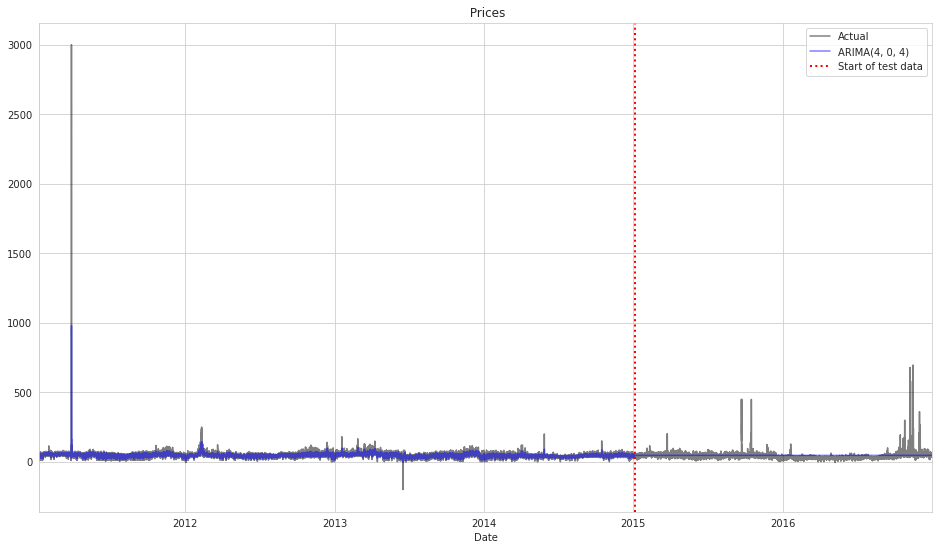

In [ ]:
# Example forecast
fcst0 = df_ex.copy()
fcst0['pred%s' % ts_ex[2:]][fcst0['pred%s' % ts_ex[2:]] < 0] = 0

fcst0.iloc[-4*prediction_length:, 0].plot(label='Actual', c='k', alpha=0.5)
fcst0.iloc[-4*prediction_length:, 1].plot(label='ARIMA%s' % str(train_params), c='b', alpha=0.5)
plt.axvline(x=fcst0.index[-prediction_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.title(ts_ex);

In [ ]:
parameters = []
results = df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    dft = df.loc[:, col]
    
    # Find best model
    fcst, train_params, summary = optimiseARIMA(dft)
    # Add predictions to results DataFrame
    results['pred%s' % col[2:]] = fcst.values
    # Store model parameteres for reference
    parameters.append(train_params)

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))

Running predictions for  Prices. Cumulative time: 0.0 minutes.
Finished! Total run time: 38.7 minutes.


In [ ]:
results0 = results.copy()
results0[results0 < 0] = 0
results0.head()

,Prices,Generation forecast,System load forecast,predrices,predeneration forecast,predystem load forecast
Date,,,,,,
2011-01-09 00:00:00,32.54,63065.0,63000.0,23.569506,56015.390223,52596.529862
2011-01-09 01:00:00,21.55,62715.0,58800.0,23.569506,56015.390223,52596.529862
2011-01-09 02:00:00,15.71,61952.0,58500.0,23.569506,56015.390223,52596.529862
2011-01-09 03:00:00,10.58,59262.0,54300.0,23.569506,56015.390223,52596.529862
2011-01-09 04:00:00,10.32,56883.0,51900.0,23.569506,56015.390223,52596.529862


In [ ]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['predrices'].iloc[-prediction_length:]))

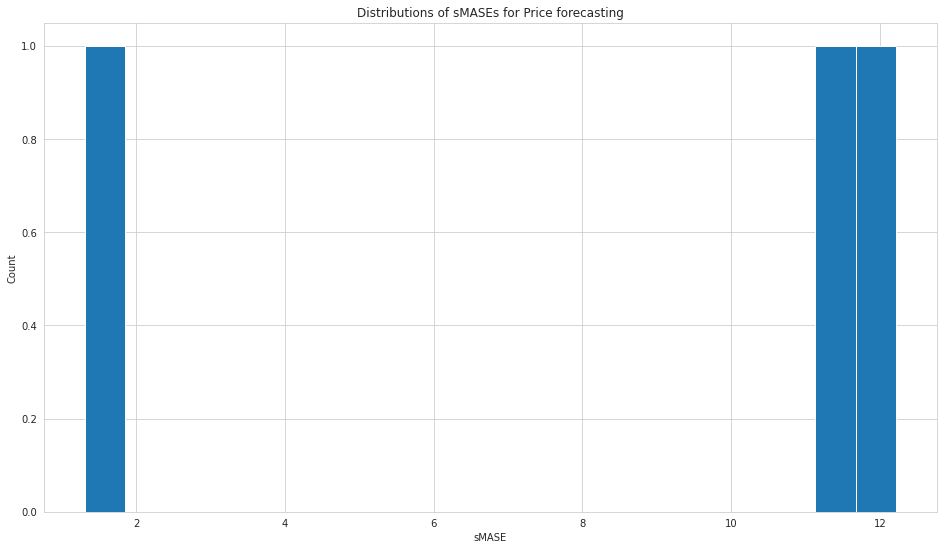

In [ ]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for Price forecasting'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [ ]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 8.2409


In [ ]:
results0['predrices']

Date
2011-01-09 00:00:00    23.569506
2011-01-09 01:00:00    23.569506
2011-01-09 02:00:00    23.569506
2011-01-09 03:00:00    23.569506
2011-01-09 04:00:00    23.569506
                         ...    
2016-12-31 19:00:00    46.095656
2016-12-31 20:00:00    46.095656
2016-12-31 21:00:00    46.095656
2016-12-31 22:00:00    46.095656
2016-12-31 23:00:00    46.095656
Name: predrices, Length: 52416, dtype: float64

In [ ]:
# Save prediction as CSV
import pandas as pd
from pandas import read_csv
import csv
Prediction=results0
Prediction=pd.DataFrame(Prediction)
print(Prediction)
Prediction.to_csv("ARMA_Prediction.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')




In [92]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)

In [105]:
Pred=results0['predrices']
original=df[' Prices']

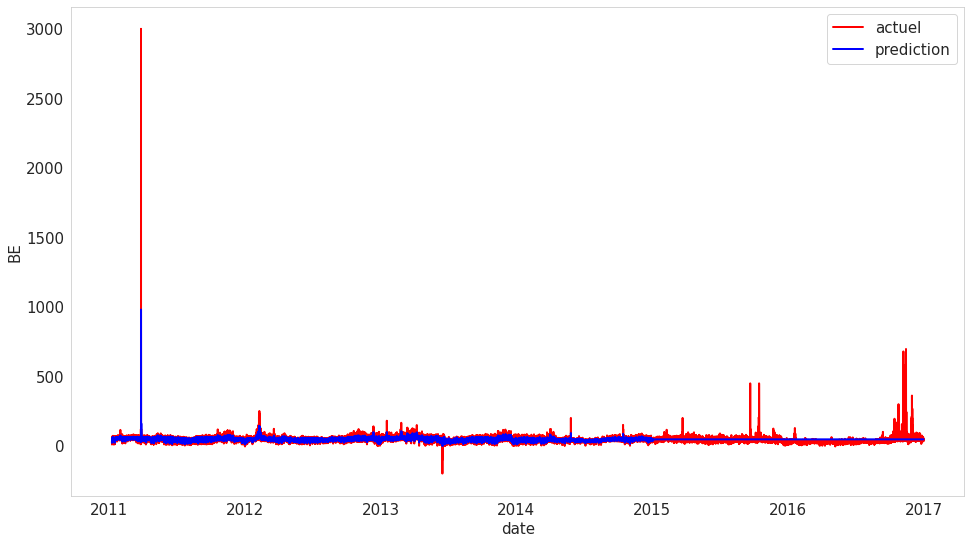

In [107]:
#Plot prediction results
# Plot

plt.plot(original,'r',lw =2)
plt.plot(Pred, color='b',lw=2)
#plt.xlim([0,525])
plt.xlabel('date', fontsize =15)
plt.ylabel('BE',fontsize =15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['actuel','prediction'],prop={'size': 15})
plt.grid()
plt.savefig('ARMA', transparent=True, dpi=300)